<a href="https://colab.research.google.com/github/pavan-charan/Fake-news-detection-QML/blob/main/Quantum_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pennylane pennylane-lightning scikit-learn pandas numpy openpyxl seaborn --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import re, time, gc

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import pennylane as qml

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#", " ", s)
    s = re.sub(r"[^a-z0-9'\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def timer():
    t=[time.time()]
    return lambda msg="": (print(f"{msg}: {time.time()-t[0]:.2f}s"), t.__setitem__(0,time.time()))

def report(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    print(f"{name} — Acc: {acc:.4f}, F1: {f1:.4f}")
    return acc, f1

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [ ]:
train_df = pd.read_excel("/content/drive/MyDrive/CovidDataset/Constraint_English_Train.xlsx")
val_df   = pd.read_excel("/content/drive/MyDrive/CovidDataset/Constraint_English_Val.xlsx")
test_df  = pd.read_excel("/content/drive/MyDrive/CovidDataset/english_test_with_labels.xlsx")

for df in (train_df, val_df, test_df):
    df["tweet"] = df["tweet"].astype(str).map(clean_text)

le = LabelEncoder()
le.fit(pd.concat([train_df["label"], val_df["label"], test_df["label"]]))

y_train = le.transform(train_df["label"])
y_val   = le.transform(val_df["label"])
y_test  = le.transform(test_df["label"])

X_train_text = train_df["tweet"].tolist()
X_val_text   = val_df["tweet"].tolist()
X_test_text  = test_df["tweet"].tolist()


In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=5000)

Xtr_tfidf = tfidf.fit_transform(X_train_text)
Xv_tfidf  = tfidf.transform(X_val_text)
Xt_tfidf  = tfidf.transform(X_test_text)

print("TF-IDF shapes:", Xtr_tfidf.shape, Xv_tfidf.shape, Xt_tfidf.shape)


TF-IDF shapes: (6420, 5000) (2140, 5000) (2140, 5000)



=== Linear SVC Validation Report ===
              precision    recall  f1-score   support

        fake       0.93      0.94      0.94      1020
        real       0.95      0.94      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140



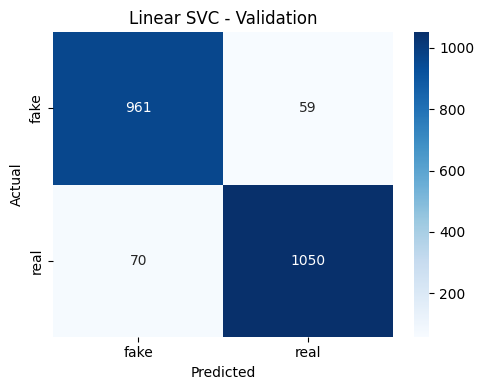


=== Linear SVC Test Report ===
              precision    recall  f1-score   support

        fake       0.93      0.93      0.93      1020
        real       0.94      0.94      0.94      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



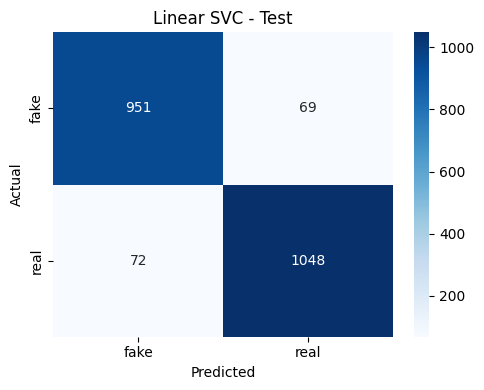

In [ ]:
clf = LinearSVC()
clf.fit(Xtr_tfidf, y_train)

pred_val = clf.predict(Xv_tfidf)
pred_test = clf.predict(Xt_tfidf)

print("\n=== Linear SVC Validation Report ===")
print(classification_report(y_val, pred_val, target_names=le.classes_))
plot_confusion_matrix(y_val, pred_val, le.classes_, "Linear SVC - Validation")

print("\n=== Linear SVC Test Report ===")
print(classification_report(y_test, pred_test, target_names=le.classes_))
plot_confusion_matrix(y_test, pred_test, le.classes_, "Linear SVC - Test")



=== RBF-SVM (TF-IDF, NO REDUCTION) ===
Training RBF-SVM on full TF-IDF… this may take a few seconds…

=== RBF-SVM (TF-IDF) Validation Report ===
              precision    recall  f1-score   support

        fake       0.93      0.94      0.94      1020
        real       0.95      0.94      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140



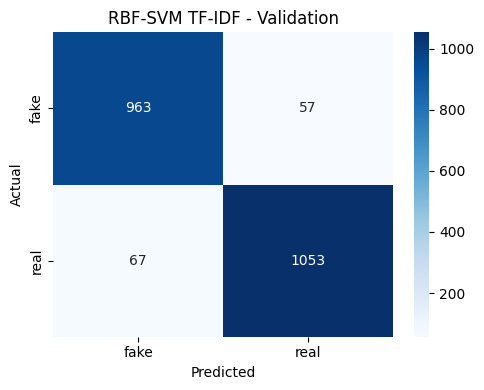


=== RBF-SVM (TF-IDF) Test Report ===
              precision    recall  f1-score   support

        fake       0.92      0.94      0.93      1020
        real       0.94      0.93      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



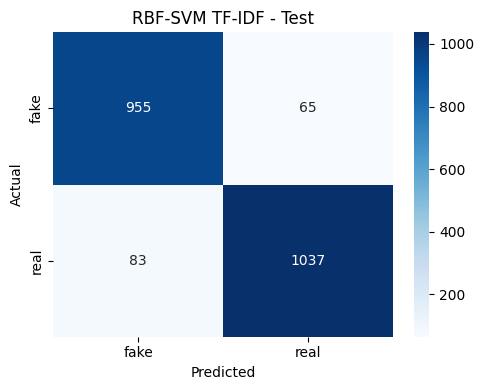

In [ ]:
print("\n=== RBF-SVM (TF-IDF, NO REDUCTION) ===")

rbf_full = SVC(kernel="rbf", C=2.0, gamma="scale")

print("Training RBF-SVM on full TF-IDF… this may take a few seconds…")
rbf_full.fit(Xtr_tfidf, y_train)

pred_val_rbf_full = rbf_full.predict(Xv_tfidf)
pred_test_rbf_full = rbf_full.predict(Xt_tfidf)

print("\n=== RBF-SVM (TF-IDF) Validation Report ===")
print(classification_report(y_val, pred_val_rbf_full, target_names=le.classes_))
plot_confusion_matrix(y_val, pred_val_rbf_full, le.classes_, "RBF-SVM TF-IDF - Validation")

print("\n=== RBF-SVM (TF-IDF) Test Report ===")
print(classification_report(y_test, pred_test_rbf_full, target_names=le.classes_))
plot_confusion_matrix(y_test, pred_test_rbf_full, le.classes_, "RBF-SVM TF-IDF - Test")



=== RBF-SVM Validation Report ===
              precision    recall  f1-score   support

        fake       0.76      0.84      0.80      1020
        real       0.84      0.77      0.80      1120

    accuracy                           0.80      2140
   macro avg       0.80      0.80      0.80      2140
weighted avg       0.80      0.80      0.80      2140



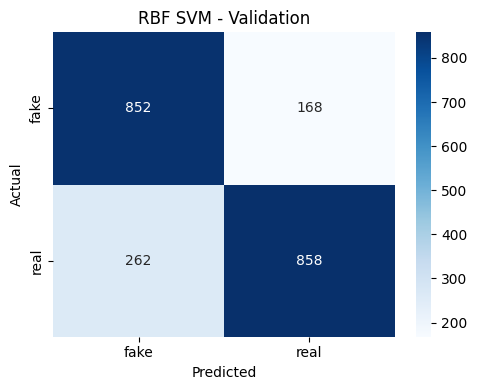


=== RBF-SVM Test Report ===
              precision    recall  f1-score   support

        fake       0.76      0.82      0.79      1020
        real       0.82      0.76      0.79      1120

    accuracy                           0.79      2140
   macro avg       0.79      0.79      0.79      2140
weighted avg       0.79      0.79      0.79      2140



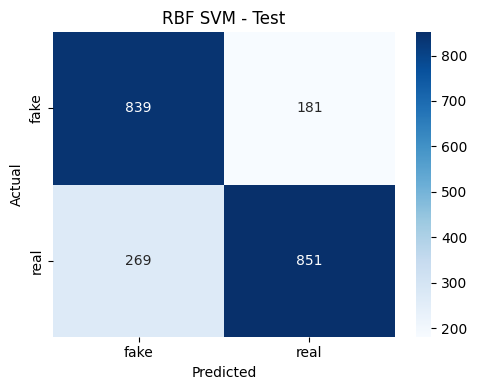

In [ ]:
svd = TruncatedSVD(n_components=5, random_state=42)
Ztr = svd.fit_transform(Xtr_tfidf)
Zv  = svd.transform(Xv_tfidf)
Zt  = svd.transform(Xt_tfidf)

rbf = SVC(kernel="rbf", C=2.0)
rbf.fit(Ztr, y_train)

pred_val = rbf.predict(Zv)
pred_test = rbf.predict(Zt)

print("\n=== RBF-SVM Validation Report ===")
print(classification_report(y_val, pred_val, target_names=le.classes_))
plot_confusion_matrix(y_val, pred_val, le.classes_, "RBF SVM - Validation")

print("\n=== RBF-SVM Test Report ===")
print(classification_report(y_test, pred_test, target_names=le.classes_))
plot_confusion_matrix(y_test, pred_test, le.classes_, "RBF SVM - Test")



=== RBF-SVM Validation Report ===
              precision    recall  f1-score   support

        fake       0.83      0.89      0.86      1020
        real       0.89      0.84      0.86      1120

    accuracy                           0.86      2140
   macro avg       0.86      0.86      0.86      2140
weighted avg       0.86      0.86      0.86      2140



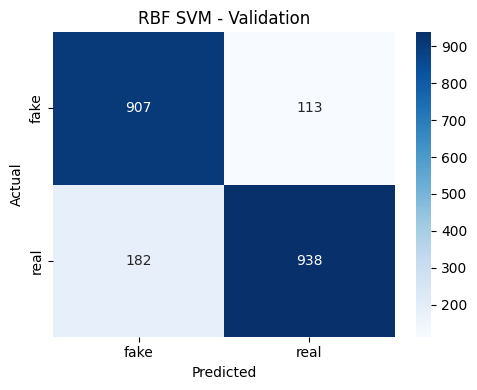


=== RBF-SVM Test Report ===
              precision    recall  f1-score   support

        fake       0.81      0.90      0.85      1020
        real       0.89      0.81      0.85      1120

    accuracy                           0.85      2140
   macro avg       0.85      0.85      0.85      2140
weighted avg       0.86      0.85      0.85      2140



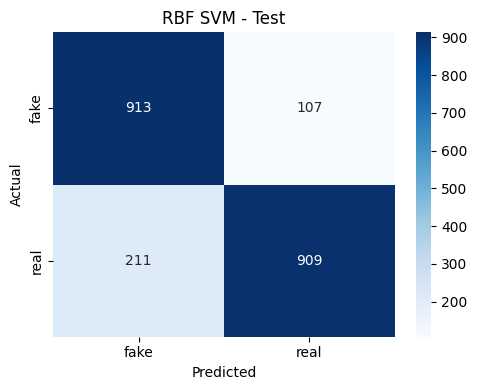

In [ ]:
svd = TruncatedSVD(n_components=10, random_state=42)
Ztr = svd.fit_transform(Xtr_tfidf)
Zv  = svd.transform(Xv_tfidf)
Zt  = svd.transform(Xt_tfidf)

rbf = SVC(kernel="rbf", C=2.0)
rbf.fit(Ztr, y_train)

pred_val = rbf.predict(Zv)
pred_test = rbf.predict(Zt)

print("\n=== RBF-SVM Validation Report ===")
print(classification_report(y_val, pred_val, target_names=le.classes_))
plot_confusion_matrix(y_val, pred_val, le.classes_, "RBF SVM - Validation")

print("\n=== RBF-SVM Test Report ===")
print(classification_report(y_test, pred_test, target_names=le.classes_))
plot_confusion_matrix(y_test, pred_test, le.classes_, "RBF SVM - Test")



=== RBF-SVM (500 samples) Validation Report ===
              precision    recall  f1-score   support

        fake       0.75      0.87      0.81      1020
        real       0.86      0.74      0.80      1120

    accuracy                           0.80      2140
   macro avg       0.81      0.81      0.80      2140
weighted avg       0.81      0.80      0.80      2140



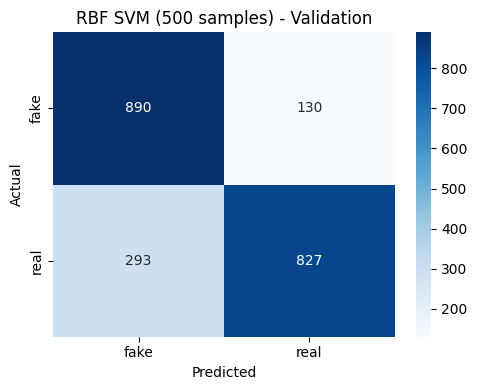


=== RBF-SVM (500 samples) Test Report ===
              precision    recall  f1-score   support

        fake       0.74      0.87      0.80      1020
        real       0.86      0.72      0.78      1120

    accuracy                           0.79      2140
   macro avg       0.80      0.80      0.79      2140
weighted avg       0.80      0.79      0.79      2140



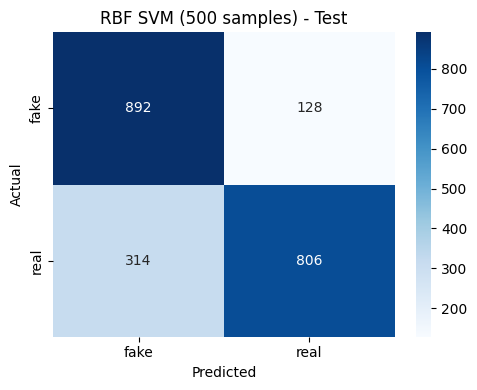

Training size actually used: 500


In [ ]:
# --- Reduce training set to 500 samples (fair comparison with quantum) ---
N_CLASSICAL = 500
rng = np.random.default_rng(42)

# Number of training samples
n_samples = Xtr_tfidf.shape[0]

# Select random 500 training indices
idx = rng.choice(n_samples, size=N_CLASSICAL, replace=False)

# Subset TF-IDF vectors and labels
Xtr_tfidf_small = Xtr_tfidf[idx]
y_train_small   = y_train[idx]

# --- SVD on reduced training set ---
svd = TruncatedSVD(n_components=5, random_state=42)
Ztr = svd.fit_transform(Xtr_tfidf_small)
Zv  = svd.transform(Xv_tfidf)
Zt  = svd.transform(Xt_tfidf)

# --- RBF-SVM ---
rbf = SVC(kernel="rbf", C=2.0)
rbf.fit(Ztr, y_train_small)

pred_val = rbf.predict(Zv)
pred_test = rbf.predict(Zt)

# --- Reports ---
print("\n=== RBF-SVM (500 samples) Validation Report ===")
print(classification_report(y_val, pred_val, target_names=le.classes_))
plot_confusion_matrix(y_val, pred_val, le.classes_, "RBF SVM (500 samples) - Validation")

print("\n=== RBF-SVM (500 samples) Test Report ===")
print(classification_report(y_test, pred_test, target_names=le.classes_))
plot_confusion_matrix(y_test, pred_test, le.classes_, "RBF SVM (500 samples) - Test")

print("Training size actually used:", len(Ztr))


Training samples used: 500
Ztr shape: (500, 5)

=== RBF-SVM (TRAIN=500, SVD=5) Validation Report ===
              precision    recall  f1-score   support

        fake       0.75      0.73      0.74      1020
        real       0.76      0.78      0.77      1120

    accuracy                           0.76      2140
   macro avg       0.76      0.76      0.76      2140
weighted avg       0.76      0.76      0.76      2140



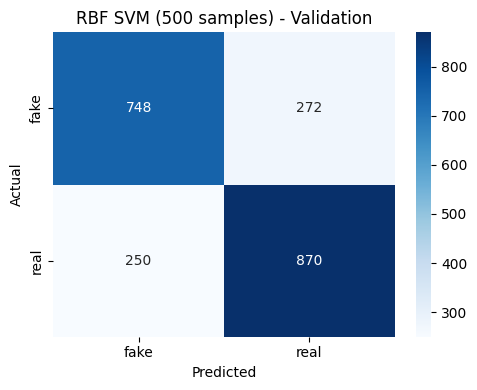


=== RBF-SVM (TRAIN=500, SVD=5) Test Report ===
              precision    recall  f1-score   support

        fake       0.74      0.74      0.74      1020
        real       0.76      0.76      0.76      1120

    accuracy                           0.75      2140
   macro avg       0.75      0.75      0.75      2140
weighted avg       0.75      0.75      0.75      2140



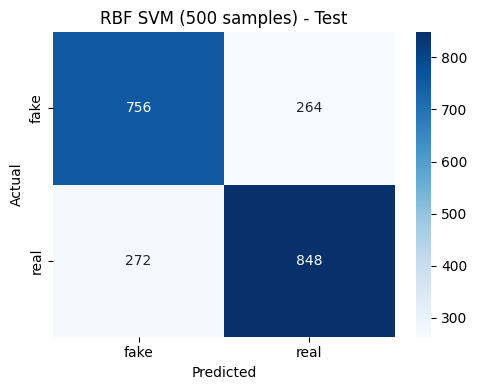

In [ ]:
# ==========================================================
# Reduce training set to EXACTLY 500 samples
# ==========================================================

N_SAMPLES = 500
rng = np.random.default_rng(10)

total_train_rows = Xtr_tfidf.shape[0]    # number of training samples

# Select 500 random training indices
idx_small = rng.choice(total_train_rows, size=N_SAMPLES, replace=False)

# Subset TF-IDF and labels
Xtr_tfidf_small = Xtr_tfidf[idx_small]
y_train_small   = y_train[idx_small]

print("Training samples used:", Xtr_tfidf_small.shape[0])

# ==========================================================
# SVD on ONLY those 500 samples!
# ==========================================================

svd = TruncatedSVD(n_components=5, random_state=100)
Ztr = svd.fit_transform(Xtr_tfidf_small)   # 500 → 5D
Zv  = svd.transform(Xv_tfidf)
Zt  = svd.transform(Xt_tfidf)

print("Ztr shape:", Ztr.shape)

# ==========================================================
# RBF-SVM trained on 500-sample SVD representation
# ==========================================================

rbf = SVC(kernel="rbf", C=20.0)
rbf.fit(Ztr, y_train_small)

# Predict
pred_val  = rbf.predict(Zv)
pred_test = rbf.predict(Zt)

# ==========================================================
# Reports + Confusion Matrices
# ==========================================================

print("\n=== RBF-SVM (TRAIN=500, SVD=5) Validation Report ===")
print(classification_report(y_val, pred_val, target_names=le.classes_))
plot_confusion_matrix(y_val, pred_val, le.classes_, "RBF SVM (500 samples) - Validation")

print("\n=== RBF-SVM (TRAIN=500, SVD=5) Test Report ===")
print(classification_report(y_test, pred_test, target_names=le.classes_))
plot_confusion_matrix(y_test, pred_test, le.classes_, "RBF SVM (500 samples) - Test")


Training samples used: 1500
Ztr shape: (1500, 5)

=== RBF-SVM (TRAIN=1500, SVD=10) Validation Report ===
              precision    recall  f1-score   support

        fake       0.76      0.82      0.79      1020
        real       0.82      0.77      0.80      1120

    accuracy                           0.79      2140
   macro avg       0.79      0.79      0.79      2140
weighted avg       0.80      0.79      0.79      2140



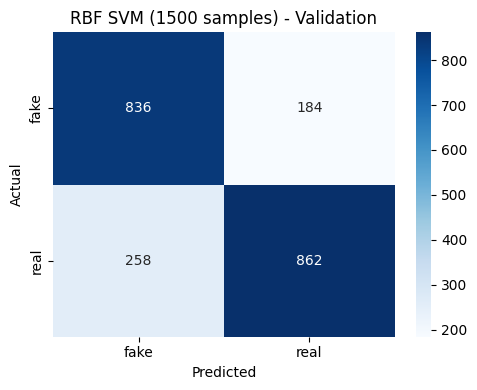


=== RBF-SVM (TRAIN=1500, SVD=10) Test Report ===
              precision    recall  f1-score   support

        fake       0.75      0.82      0.78      1020
        real       0.82      0.76      0.79      1120

    accuracy                           0.79      2140
   macro avg       0.79      0.79      0.79      2140
weighted avg       0.79      0.79      0.79      2140



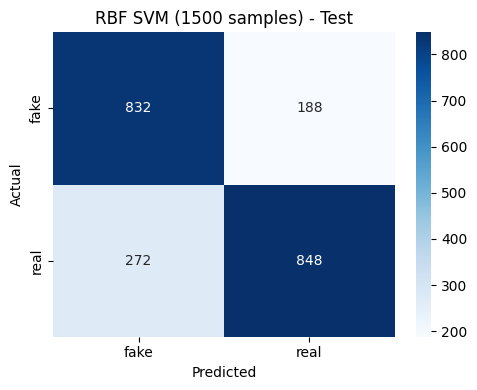

In [ ]:
# ==========================================================
# Reduce training set to EXACTLY 500 samples
# ==========================================================

N_SAMPLES = 1500
rng = np.random.default_rng(10)

total_train_rows = Xtr_tfidf.shape[0]    # number of training samples

# Select 500 random training indices
idx_small = rng.choice(total_train_rows, size=N_SAMPLES, replace=False)

# Subset TF-IDF and labels
Xtr_tfidf_small = Xtr_tfidf[idx_small]
y_train_small   = y_train[idx_small]

print("Training samples used:", Xtr_tfidf_small.shape[0])

# ==========================================================
# SVD on ONLY those 500 samples!
# ==========================================================

svd = TruncatedSVD(n_components=5, random_state=1000)
Ztr = svd.fit_transform(Xtr_tfidf_small)   # 500 → 5D
Zv  = svd.transform(Xv_tfidf)
Zt  = svd.transform(Xt_tfidf)

print("Ztr shape:", Ztr.shape)

# ==========================================================
# RBF-SVM trained on 500-sample SVD representation
# ==========================================================

rbf = SVC(kernel="rbf", C=20.0)
rbf.fit(Ztr, y_train_small)

# Predict
pred_val  = rbf.predict(Zv)
pred_test = rbf.predict(Zt)

# ==========================================================
# Reports + Confusion Matrices
# ==========================================================

print("\n=== RBF-SVM (TRAIN=1500, SVD=10) Validation Report ===")
print(classification_report(y_val, pred_val, target_names=le.classes_))
plot_confusion_matrix(y_val, pred_val, le.classes_, "RBF SVM (1500 samples) - Validation")

print("\n=== RBF-SVM (TRAIN=1500, SVD=10) Test Report ===")
print(classification_report(y_test, pred_test, target_names=le.classes_))
plot_confusion_matrix(y_test, pred_test, le.classes_, "RBF SVM (1500 samples) - Test")


Training samples used: 2500
Ztr shape: (2500, 10)

=== RBF-SVM (TRAIN=2500, SVD=10) Validation Report ===
              precision    recall  f1-score   support

        fake       0.82      0.83      0.82      1020
        real       0.84      0.83      0.84      1120

    accuracy                           0.83      2140
   macro avg       0.83      0.83      0.83      2140
weighted avg       0.83      0.83      0.83      2140



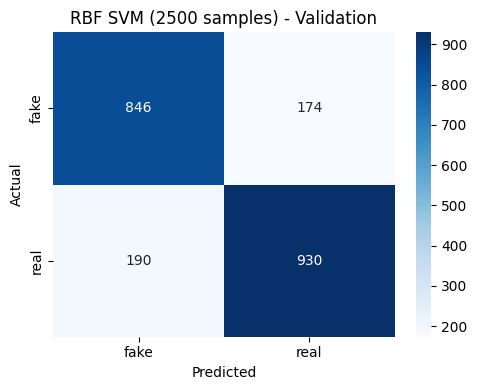


=== RBF-SVM (TRAIN=2500, SVD=10) Test Report ===
              precision    recall  f1-score   support

        fake       0.80      0.85      0.82      1020
        real       0.85      0.80      0.83      1120

    accuracy                           0.82      2140
   macro avg       0.82      0.82      0.82      2140
weighted avg       0.83      0.82      0.82      2140



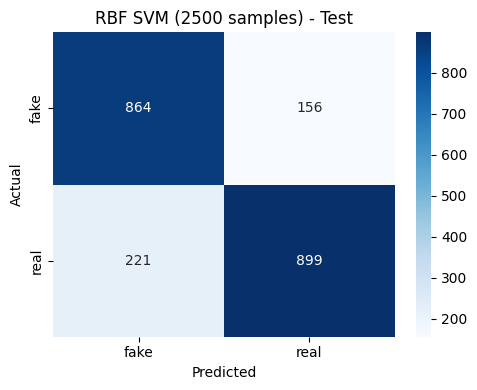

In [ ]:
# ==========================================================
# Reduce training set to EXACTLY 500 samples
# ==========================================================

N_SAMPLES = 2500
rng = np.random.default_rng(20)

total_train_rows = Xtr_tfidf.shape[0]    # number of training samples

# Select 500 random training indices
idx_small = rng.choice(total_train_rows, size=N_SAMPLES, replace=False)

# Subset TF-IDF and labels
Xtr_tfidf_small = Xtr_tfidf[idx_small]
y_train_small   = y_train[idx_small]

print("Training samples used:", Xtr_tfidf_small.shape[0])

# ==========================================================
# SVD on ONLY those 500 samples!
# ==========================================================

svd = TruncatedSVD(n_components=10, random_state=1000)
Ztr = svd.fit_transform(Xtr_tfidf_small)   # 500 → 5D
Zv  = svd.transform(Xv_tfidf)
Zt  = svd.transform(Xt_tfidf)

print("Ztr shape:", Ztr.shape)

# ==========================================================
# RBF-SVM trained on 500-sample SVD representation
# ==========================================================

rbf = SVC(kernel="rbf", C=2000)
rbf.fit(Ztr, y_train_small)

# Predict
pred_val  = rbf.predict(Zv)
pred_test = rbf.predict(Zt)

# ==========================================================
# Reports + Confusion Matrices
# ==========================================================

print("\n=== RBF-SVM (TRAIN=2500, SVD=10) Validation Report ===")
print(classification_report(y_val, pred_val, target_names=le.classes_))
plot_confusion_matrix(y_val, pred_val, le.classes_, "RBF SVM (2500 samples) - Validation")

print("\n=== RBF-SVM (TRAIN=2500, SVD=10) Test Report ===")
print(classification_report(y_test, pred_test, target_names=le.classes_))
plot_confusion_matrix(y_test, pred_test, le.classes_, "RBF SVM (2500 samples) - Test")


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 2*np.pi))
Xtr_scaled = scaler.fit_transform(Ztr)
Xv_scaled  = scaler.transform(Zv)
Xt_scaled  = scaler.transform(Zt)


In [ ]:
n_qubits = 5

try:
    dev = qml.device("lightning.qubit", wires=n_qubits)
    print("Using lightning.qubit (fast CPU backend)")
except:
    dev = qml.device("default.qubit", wires=n_qubits)
    print("Using default.qubit (fallback)")


def feature_map(x):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RZ(x[i], wires=i)
    for i in range(n_qubits):
        j = (i + 1) % n_qubits
        qml.CNOT(wires=[i, j])
        qml.RZ(2*x[i]*x[j], wires=j)
        qml.CNOT(wires=[i, j])


@qml.qnode(dev)
def quantum_state(x):
    feature_map(x)
    return qml.state()


Using lightning.qubit (fast CPU backend)


In [ ]:
def kernel_matrix(A, B):
    NA, NB = len(A), len(B)
    K = np.zeros((NA, NB))
    for i in range(NA):
        psi_i = quantum_state(A[i])
        for j in range(NB):
            psi_j = quantum_state(B[j])
            K[i, j] = float(np.abs(np.vdot(psi_i, psi_j))**2)
        if (i+1) % 20 == 0:
            print(f"  built row {i+1}/{NA}")
    return K

TRAIN_Q = 500
VAL_Q = None
TEST_Q = None

def cap(X, y, n):
    if n is None or n >= len(X):
        return X, y
    idx = np.random.choice(len(X), n, replace=False)
    return X[idx], y[idx]

Xtr_q, ytr_q = cap(Xtr_scaled, y_train, TRAIN_Q)
Xv_q, yv_q   = cap(Xv_scaled,  y_val, VAL_Q)
Xt_q, yt_q   = cap(Xt_scaled,  y_test, TEST_Q)

print("Quantum sizes:", len(Xtr_q), len(Xv_q), len(Xt_q))


Quantum sizes: 500 2140 2140



=== Building K_train ===
  built row 20/500
  built row 40/500
  built row 60/500
  built row 80/500
  built row 100/500
  built row 120/500
  built row 140/500
  built row 160/500
  built row 180/500
  built row 200/500
  built row 220/500
  built row 240/500
  built row 260/500
  built row 280/500
  built row 300/500
  built row 320/500
  built row 340/500
  built row 360/500
  built row 380/500
  built row 400/500
  built row 420/500
  built row 440/500
  built row 460/500
  built row 480/500
  built row 500/500

=== Building K_val and K_test ===
  built row 20/2140
  built row 40/2140
  built row 60/2140
  built row 80/2140
  built row 100/2140
  built row 120/2140
  built row 140/2140
  built row 160/2140
  built row 180/2140
  built row 200/2140
  built row 220/2140
  built row 240/2140
  built row 260/2140
  built row 280/2140
  built row 300/2140
  built row 320/2140
  built row 340/2140
  built row 360/2140
  built row 380/2140
  built row 400/2140
  built row 420/2140
  buil

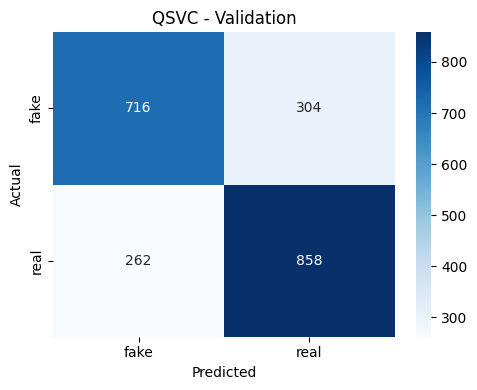


=== QSVC Test Report ===
              precision    recall  f1-score   support

        fake       0.74      0.74      0.74      1020
        real       0.76      0.76      0.76      1120

    accuracy                           0.75      2140
   macro avg       0.75      0.75      0.75      2140
weighted avg       0.75      0.75      0.75      2140



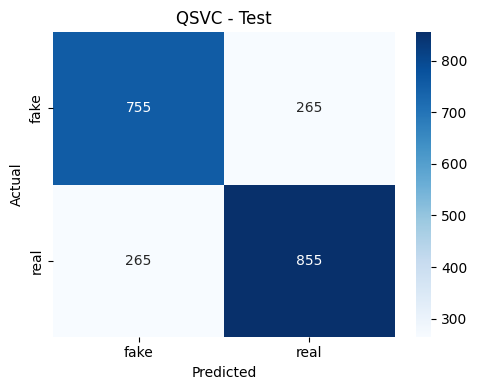

In [ ]:
print("\n=== Building K_train ===")
K_train = kernel_matrix(Xtr_q, Xtr_q)

print("\n=== Building K_val and K_test ===")
K_val  = kernel_matrix(Xv_q, Xtr_q)
K_test = kernel_matrix(Xt_q, Xtr_q)

qsvc = SVC(kernel="precomputed", C=2.0)
qsvc.fit(K_train, ytr_q)

pred_val_q  = qsvc.predict(K_val)
pred_test_q = qsvc.predict(K_test)

print("\n=== QSVC Validation Report ===")
print(classification_report(yv_q, pred_val_q, target_names=le.classes_))
plot_confusion_matrix(yv_q, pred_val_q, le.classes_, "QSVC - Validation")

print("\n=== QSVC Test Report ===")
print(classification_report(yt_q, pred_test_q, target_names=le.classes_))
plot_confusion_matrix(yt_q, pred_test_q, le.classes_, "QSVC - Test")


In [ ]:
def kernel_matrix(A, B):
    NA, NB = len(A), len(B)
    K = np.zeros((NA, NB))
    for i in range(NA):
        psi_i = quantum_state(A[i])
        for j in range(NB):
            psi_j = quantum_state(B[j])
            K[i, j] = float(np.abs(np.vdot(psi_i, psi_j))**2)
        if (i+1) % 20 == 0:
            print(f"  built row {i+1}/{NA}")
    return K

TRAIN_Q = 2000
VAL_Q = None
TEST_Q = None

def cap(X, y, n):
    if n is None or n >= len(X):
        return X, y
    idx = np.random.choice(len(X), n, replace=False)
    return X[idx], y[idx]

Xtr_q, ytr_q = cap(Xtr_scaled, y_train, TRAIN_Q)
Xv_q, yv_q   = cap(Xv_scaled,  y_val, VAL_Q)
Xt_q, yt_q   = cap(Xt_scaled,  y_test, TEST_Q)

print("Quantum sizes:", len(Xtr_q), len(Xv_q), len(Xt_q))


Quantum sizes: 2000 2140 2140


In [ ]:
print("\n=== Building K_train ===")
K_train = kernel_matrix(Xtr_q, Xtr_q)

print("\n=== Building K_val and K_test ===")
# K_val  = kernel_matrix(Xv_q, Xtr_q)
K_test = kernel_matrix(Xt_q, Xtr_q)

qsvc = SVC(kernel="precomputed", C=2.0)
qsvc.fit(K_train, ytr_q)

# pred_val_q  = qsvc.predict(K_val)
pred_test_q = qsvc.predict(K_test)

# print("\n=== QSVC Validation Report ===")
# print(classification_report(yv_q, pred_val_q, target_names=le.classes_))
# plot_confusion_matrix(yv_q, pred_val_q, le.classes_, "QSVC - Validation")

print("\n=== QSVC Test Report ===")
print(classification_report(yt_q, pred_test_q, target_names=le.classes_))
plot_confusion_matrix(yt_q, pred_test_q, le.classes_, "QSVC - Test")



=== Building K_train ===
  built row 20/4000
  built row 40/4000
  built row 60/4000
  built row 80/4000
  built row 100/4000
  built row 120/4000
  built row 140/4000
  built row 160/4000
  built row 180/4000
  built row 200/4000
  built row 220/4000
  built row 240/4000
  built row 260/4000
  built row 280/4000
  built row 300/4000
  built row 320/4000
  built row 340/4000
  built row 360/4000
  built row 380/4000
  built row 400/4000
  built row 420/4000
  built row 440/4000
  built row 460/4000
  built row 480/4000
  built row 500/4000
  built row 520/4000
  built row 540/4000
  built row 560/4000
  built row 580/4000
  built row 600/4000
  built row 620/4000
  built row 640/4000
  built row 660/4000
  built row 680/4000
  built row 700/4000
  built row 720/4000
  built row 740/4000
  built row 760/4000
  built row 780/4000
  built row 800/4000
  built row 820/4000
  built row 840/4000
  built row 860/4000
  built row 880/4000
  built row 900/4000
  built row 920/4000
  built row 

In [ ]:
# Use SVD = 10 so that quantum gets 10 features
svd = TruncatedSVD(n_components=10, random_state=42)
Ztr = svd.fit_transform(Xtr_tfidf)
Zv  = svd.transform(Xv_tfidf)
Zt  = svd.transform(Xt_tfidf)

print("Ztr shape:", Ztr.shape)  # should be (num_samples, 10)


Ztr shape: (6420, 10)


In [ ]:
TRAIN_Q = 1500    # safe
# TRAIN_Q = 2000  # borderline
# TRAIN_Q = 4000  # risky (very heavy)

scaler = MinMaxScaler(feature_range=(0, 2*np.pi))
Xtr_s = scaler.fit_transform(Ztr)
Xv_s  = scaler.transform(Zv)
Xt_s  = scaler.transform(Zt)

def cap(X, y, n):
    idx = np.random.choice(len(X), n, replace=True)
    return X[idx], y[idx]

Xtr_q, ytr_q = cap(Xtr_s, y_train, TRAIN_Q)
Xv_q, yv_q   = Xv_s, y_val
Xt_q, yt_q   = Xt_s, y_test

print("Quantum train size =", len(Xtr_q))


Quantum train size = 1500


In [ ]:
n_qubits = 10

try:
    dev = qml.device("lightning.qubit", wires=n_qubits)
    print("Using lightning.qubit backend")
except:
    dev = qml.device("default.qubit", wires=n_qubits)
    print("Using default.qubit backend")

REPS = 3

def feature_map(x):
    for r in range(REPS):
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)
            qml.RZ(x[i]**2, wires=i)
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])

@qml.qnode(dev)
def quantum_state(x):
    feature_map(x)
    return qml.state()


Using lightning.qubit backend


In [ ]:
state_cache = {}

def get_state(x_tuple):
    if x_tuple not in state_cache:
        state_cache[x_tuple] = quantum_state(np.array(x_tuple))
    return state_cache[x_tuple]

def kernel_matrix(A, B):
    NA, NB = len(A), len(B)
    K = np.zeros((NA, NB))
    for i in range(NA):
        a_tuple = tuple(A[i])
        psi_a = get_state(a_tuple)
        for j in range(NB):
            b_tuple = tuple(B[j])
            psi_b = get_state(b_tuple)
            K[i, j] = float(np.abs(np.vdot(psi_a, psi_b))**2)
        if (i+1) % 50 == 0:
            print(f"Built {i+1}/{NA} rows")
    return K


Building training kernel...
Built 50/1500 rows
Built 100/1500 rows
Built 150/1500 rows
Built 200/1500 rows
Built 250/1500 rows
Built 300/1500 rows
Built 350/1500 rows
Built 400/1500 rows
Built 450/1500 rows
Built 500/1500 rows
Built 550/1500 rows
Built 600/1500 rows
Built 650/1500 rows
Built 700/1500 rows
Built 750/1500 rows
Built 800/1500 rows
Built 850/1500 rows
Built 900/1500 rows
Built 950/1500 rows
Built 1000/1500 rows
Built 1050/1500 rows
Built 1100/1500 rows
Built 1150/1500 rows
Built 1200/1500 rows
Built 1250/1500 rows
Built 1300/1500 rows
Built 1350/1500 rows
Built 1400/1500 rows
Built 1450/1500 rows
Built 1500/1500 rows
Training QSVC...
Building validation kernel...
Built 50/2140 rows
Built 100/2140 rows
Built 150/2140 rows
Built 200/2140 rows
Built 250/2140 rows
Built 300/2140 rows
Built 350/2140 rows
Built 400/2140 rows
Built 450/2140 rows
Built 500/2140 rows
Built 550/2140 rows
Built 600/2140 rows
Built 650/2140 rows
Built 700/2140 rows
Built 750/2140 rows
Built 800/2140 r

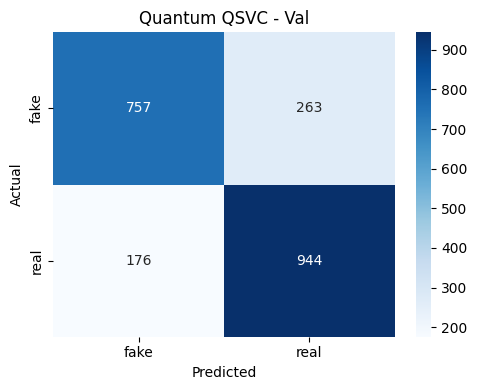


Test Report:
              precision    recall  f1-score   support

        fake       0.81      0.77      0.79      1020
        real       0.80      0.83      0.82      1120

    accuracy                           0.81      2140
   macro avg       0.81      0.80      0.80      2140
weighted avg       0.81      0.81      0.81      2140



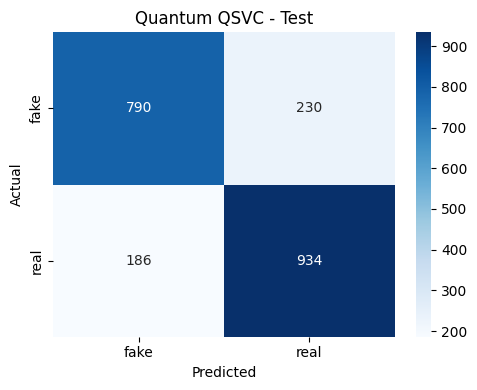

In [ ]:
print("Building training kernel...")
K_train = kernel_matrix(Xtr_q, Xtr_q)

print("Training QSVC...")
qsvc = SVC(kernel="precomputed", C=2.0)
qsvc.fit(K_train, ytr_q)

print("Building validation kernel...")
K_val = kernel_matrix(Xv_q, Xtr_q)

print("Building test kernel...")
K_test = kernel_matrix(Xt_q, Xtr_q)

pred_val_q = qsvc.predict(K_val)
pred_test_q = qsvc.predict(K_test)

print("\nQuantum QSVC Results")
print("\nValidation Report:")
print(classification_report(yv_q, pred_val_q, target_names=le.classes_))
plot_confusion_matrix(yv_q, pred_val_q, le.classes_, "Quantum QSVC - Val")

print("\nTest Report:")
print(classification_report(yt_q, pred_test_q, target_names=le.classes_))
plot_confusion_matrix(yt_q, pred_test_q, le.classes_, "Quantum QSVC - Test")


In [ ]:
# Use SVD = 10 so that quantum gets 10 features
svd = TruncatedSVD(n_components=10, random_state=42)
Ztr = svd.fit_transform(Xtr_tfidf)
Zv  = svd.transform(Xv_tfidf)
Zt  = svd.transform(Xt_tfidf)

print("Ztr shape:", Ztr.shape)  # should be (num_samples, 10)


Ztr shape: (6420, 10)


In [ ]:

TRAIN_Q = 2500  # borderline
# TRAIN_Q = 4000  # risky (very heavy)

scaler = MinMaxScaler(feature_range=(0, 2*np.pi))
Xtr_s = scaler.fit_transform(Ztr)
Xv_s  = scaler.transform(Zv)
Xt_s  = scaler.transform(Zt)

def cap(X, y, n):
    idx = np.random.choice(len(X), n, replace=True)
    return X[idx], y[idx]

Xtr_q, ytr_q = cap(Xtr_s, y_train, TRAIN_Q)
Xv_q, yv_q   = Xv_s, y_val
Xt_q, yt_q   = Xt_s, y_test

print("Quantum train size =", len(Xtr_q))


Quantum train size = 2500


In [ ]:
n_qubits = 10

try:
    dev = qml.device("lightning.qubit", wires=n_qubits)
    print("Using lightning.qubit backend")
except:
    dev = qml.device("default.qubit", wires=n_qubits)
    print("Using default.qubit backend")

REPS = 3

def feature_map(x):
    for r in range(REPS):
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)
            qml.RZ(x[i]**2, wires=i)
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])

@qml.qnode(dev)
def quantum_state(x):
    feature_map(x)
    return qml.state()


Using lightning.qubit backend


In [ ]:
state_cache = {}

def get_state(x_tuple):
    if x_tuple not in state_cache:
        state_cache[x_tuple] = quantum_state(np.array(x_tuple))
    return state_cache[x_tuple]

def kernel_matrix(A, B):
    NA, NB = len(A), len(B)
    K = np.zeros((NA, NB))
    for i in range(NA):
        a_tuple = tuple(A[i])
        psi_a = get_state(a_tuple)
        for j in range(NB):
            b_tuple = tuple(B[j])
            psi_b = get_state(b_tuple)
            K[i, j] = float(np.abs(np.vdot(psi_a, psi_b))**2)
        if (i+1) % 50 == 0:
            print(f"Built {i+1}/{NA} rows")
    return K


Building training kernel...
Built 50/2500 rows
Built 100/2500 rows
Built 150/2500 rows
Built 200/2500 rows
Built 250/2500 rows
Built 300/2500 rows
Built 350/2500 rows
Built 400/2500 rows
Built 450/2500 rows
Built 500/2500 rows
Built 550/2500 rows
Built 600/2500 rows
Built 650/2500 rows
Built 700/2500 rows
Built 750/2500 rows
Built 800/2500 rows
Built 850/2500 rows
Built 900/2500 rows
Built 950/2500 rows
Built 1000/2500 rows
Built 1050/2500 rows
Built 1100/2500 rows
Built 1150/2500 rows
Built 1200/2500 rows
Built 1250/2500 rows
Built 1300/2500 rows
Built 1350/2500 rows
Built 1400/2500 rows
Built 1450/2500 rows
Built 1500/2500 rows
Built 1550/2500 rows
Built 1600/2500 rows
Built 1650/2500 rows
Built 1700/2500 rows
Built 1750/2500 rows
Built 1800/2500 rows
Built 1850/2500 rows
Built 1900/2500 rows
Built 1950/2500 rows
Built 2000/2500 rows
Built 2050/2500 rows
Built 2100/2500 rows
Built 2150/2500 rows
Built 2200/2500 rows
Built 2250/2500 rows
Built 2300/2500 rows
Built 2350/2500 rows
Built

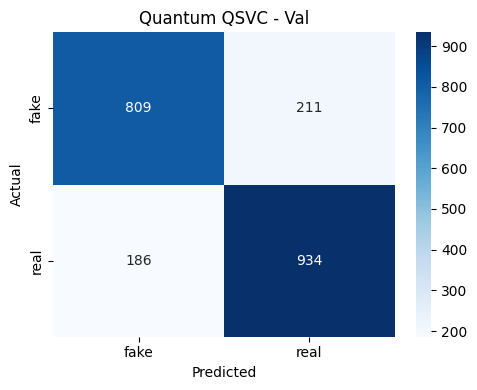


Test Report:
              precision    recall  f1-score   support

        fake       0.80      0.82      0.81      1020
        real       0.83      0.81      0.82      1120

    accuracy                           0.82      2140
   macro avg       0.82      0.82      0.82      2140
weighted avg       0.82      0.82      0.82      2140



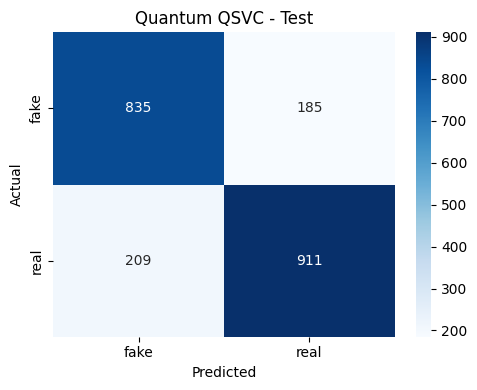

In [ ]:
print("Building training kernel...")
K_train = kernel_matrix(Xtr_q, Xtr_q)

print("Training QSVC...")
qsvc = SVC(kernel="precomputed", C=2.0)
qsvc.fit(K_train, ytr_q)

print("Building validation kernel...")
K_val = kernel_matrix(Xv_q, Xtr_q)

print("Building test kernel...")
K_test = kernel_matrix(Xt_q, Xtr_q)

pred_val_q = qsvc.predict(K_val)
pred_test_q = qsvc.predict(K_test)

print("\nQuantum QSVC Results")
print("\nValidation Report:")
print(classification_report(yv_q, pred_val_q, target_names=le.classes_))
plot_confusion_matrix(yv_q, pred_val_q, le.classes_, "Quantum QSVC - Val")

print("\nTest Report:")
print(classification_report(yt_q, pred_test_q, target_names=le.classes_))
plot_confusion_matrix(yt_q, pred_test_q, le.classes_, "Quantum QSVC - Test")


In [ ]:
# Use SVD = 10 so that quantum gets 10 features
svd = TruncatedSVD(n_components=10, random_state=42)
Ztr = svd.fit_transform(Xtr_tfidf)
Zv  = svd.transform(Xv_tfidf)
Zt  = svd.transform(Xt_tfidf)

print("Ztr shape:", Ztr.shape)  # should be (num_samples, 10)


Ztr shape: (6420, 10)


In [ ]:

TRAIN_Q = 6420 # borderline
# TRAIN_Q = 4000  # risky (very heavy)

scaler = MinMaxScaler(feature_range=(0, 2*np.pi))
Xtr_s = scaler.fit_transform(Ztr)
Xv_s  = scaler.transform(Zv)
Xt_s  = scaler.transform(Zt)

def cap(X, y, n):
    idx = np.random.choice(len(X), n, replace=True)
    return X[idx], y[idx]

Xtr_q, ytr_q = cap(Xtr_s, y_train, TRAIN_Q)
Xv_q, yv_q   = Xv_s, y_val
Xt_q, yt_q   = Xt_s, y_test

print("Quantum train size =", len(Xtr_q))


Quantum train size = 6420


In [ ]:
n_qubits = 10

try:
    dev = qml.device("lightning.qubit", wires=n_qubits)
    print("Using lightning.qubit backend")
except:
    dev = qml.device("default.qubit", wires=n_qubits)
    print("Using default.qubit backend")

REPS = 3

def feature_map(x):
    for r in range(REPS):
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)
            qml.RZ(x[i]**2, wires=i)
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])

@qml.qnode(dev)
def quantum_state(x):
    feature_map(x)
    return qml.state()


Using lightning.qubit backend


In [ ]:
state_cache = {}

def get_state(x_tuple):
    if x_tuple not in state_cache:
        state_cache[x_tuple] = quantum_state(np.array(x_tuple))
    return state_cache[x_tuple]

def kernel_matrix(A, B):
    NA, NB = len(A), len(B)
    K = np.zeros((NA, NB))
    for i in range(NA):
        a_tuple = tuple(A[i])
        psi_a = get_state(a_tuple)
        for j in range(NB):
            b_tuple = tuple(B[j])
            psi_b = get_state(b_tuple)
            K[i, j] = float(np.abs(np.vdot(psi_a, psi_b))**2)
        if (i+1) % 50 == 0:
            print(f"Built {i+1}/{NA} rows")
    return K


Building training kernel...
Built 50/6420 rows
Built 100/6420 rows
Built 150/6420 rows
Built 200/6420 rows
Built 250/6420 rows
Built 300/6420 rows
Built 350/6420 rows
Built 400/6420 rows
Built 450/6420 rows
Built 500/6420 rows
Built 550/6420 rows
Built 600/6420 rows
Built 650/6420 rows
Built 700/6420 rows
Built 750/6420 rows
Built 800/6420 rows
Built 850/6420 rows
Built 900/6420 rows
Built 950/6420 rows
Built 1000/6420 rows
Built 1050/6420 rows
Built 1100/6420 rows
Built 1150/6420 rows
Built 1200/6420 rows
Built 1250/6420 rows
Built 1300/6420 rows
Built 1350/6420 rows
Built 1400/6420 rows
Built 1450/6420 rows
Built 1500/6420 rows
Built 1550/6420 rows
Built 1600/6420 rows
Built 1650/6420 rows
Built 1700/6420 rows
Built 1750/6420 rows
Built 1800/6420 rows
Built 1850/6420 rows
Built 1900/6420 rows
Built 1950/6420 rows
Built 2000/6420 rows
Built 2050/6420 rows
Built 2100/6420 rows
Built 2150/6420 rows
Built 2200/6420 rows
Built 2250/6420 rows
Built 2300/6420 rows
Built 2350/6420 rows
Built

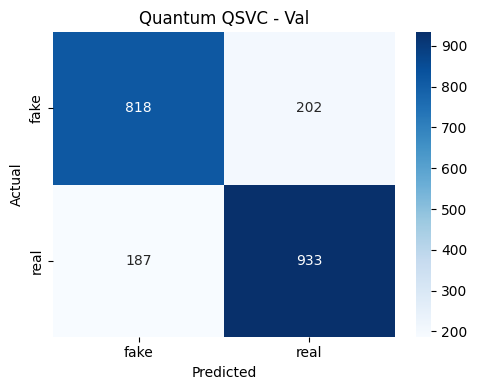


Test Report:
              precision    recall  f1-score   support

        fake       0.80      0.81      0.81      1020
        real       0.83      0.82      0.82      1120

    accuracy                           0.81      2140
   macro avg       0.81      0.81      0.81      2140
weighted avg       0.82      0.81      0.81      2140



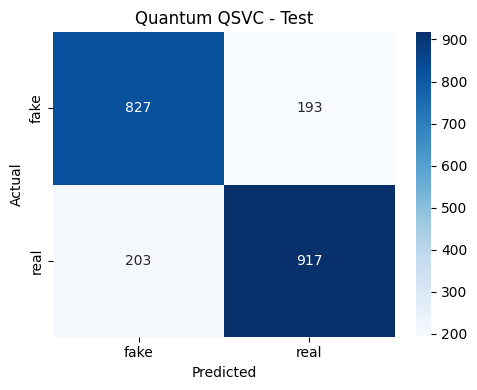

In [ ]:
print("Building training kernel...")
K_train = kernel_matrix(Xtr_q, Xtr_q)

print("Training QSVC...")
qsvc = SVC(kernel="precomputed", C=2.0)
qsvc.fit(K_train, ytr_q)

print("Building validation kernel...")
K_val = kernel_matrix(Xv_q, Xtr_q)

print("Building test kernel...")
K_test = kernel_matrix(Xt_q, Xtr_q)

pred_val_q = qsvc.predict(K_val)
pred_test_q = qsvc.predict(K_test)

print("\nQuantum QSVC Results")
print("\nValidation Report:")
print(classification_report(yv_q, pred_val_q, target_names=le.classes_))
plot_confusion_matrix(yv_q, pred_val_q, le.classes_, "Quantum QSVC - Val")

print("\nTest Report:")
print(classification_report(yt_q, pred_test_q, target_names=le.classes_))
plot_confusion_matrix(yt_q, pred_test_q, le.classes_, "Quantum QSVC - Test")


0: ──RY(0.00)──RZ(0.00)─╭●──RY(0.00)──RZ(0.00)───────────╭●─────────RY(0.00)──RZ(0.00)────────── ···
1: ──RY(0.00)──RZ(0.00)─╰Z─╭●─────────RY(0.00)──RZ(0.00)─╰Z────────╭●─────────RY(0.00)──RZ(0.00) ···
2: ──RY(0.00)──RZ(0.00)────╰Z────────╭●─────────RY(0.00)──RZ(0.00)─╰Z────────╭●─────────RY(0.00) ···
3: ──RY(0.00)──RZ(0.00)──────────────╰Z────────╭●─────────RY(0.00)──RZ(0.00)─╰Z────────╭●─────── ···
4: ──RY(0.00)──RZ(0.00)────────────────────────╰Z────────╭●─────────RY(0.00)──RZ(0.00)─╰Z─────── ···
5: ──RY(0.00)──RZ(0.00)──────────────────────────────────╰Z────────╭●─────────RY(0.00)──RZ(0.00) ···
6: ──RY(0.00)──RZ(0.00)────────────────────────────────────────────╰Z────────╭●─────────RY(0.00) ···
7: ──RY(0.00)──RZ(0.00)──────────────────────────────────────────────────────╰Z────────╭●─────── ···
8: ──RY(0.00)──RZ(0.00)────────────────────────────────────────────────────────────────╰Z─────── ···
9: ──RY(0.00)──RZ(0.00)────────────────────────────────────────────────────────────────────

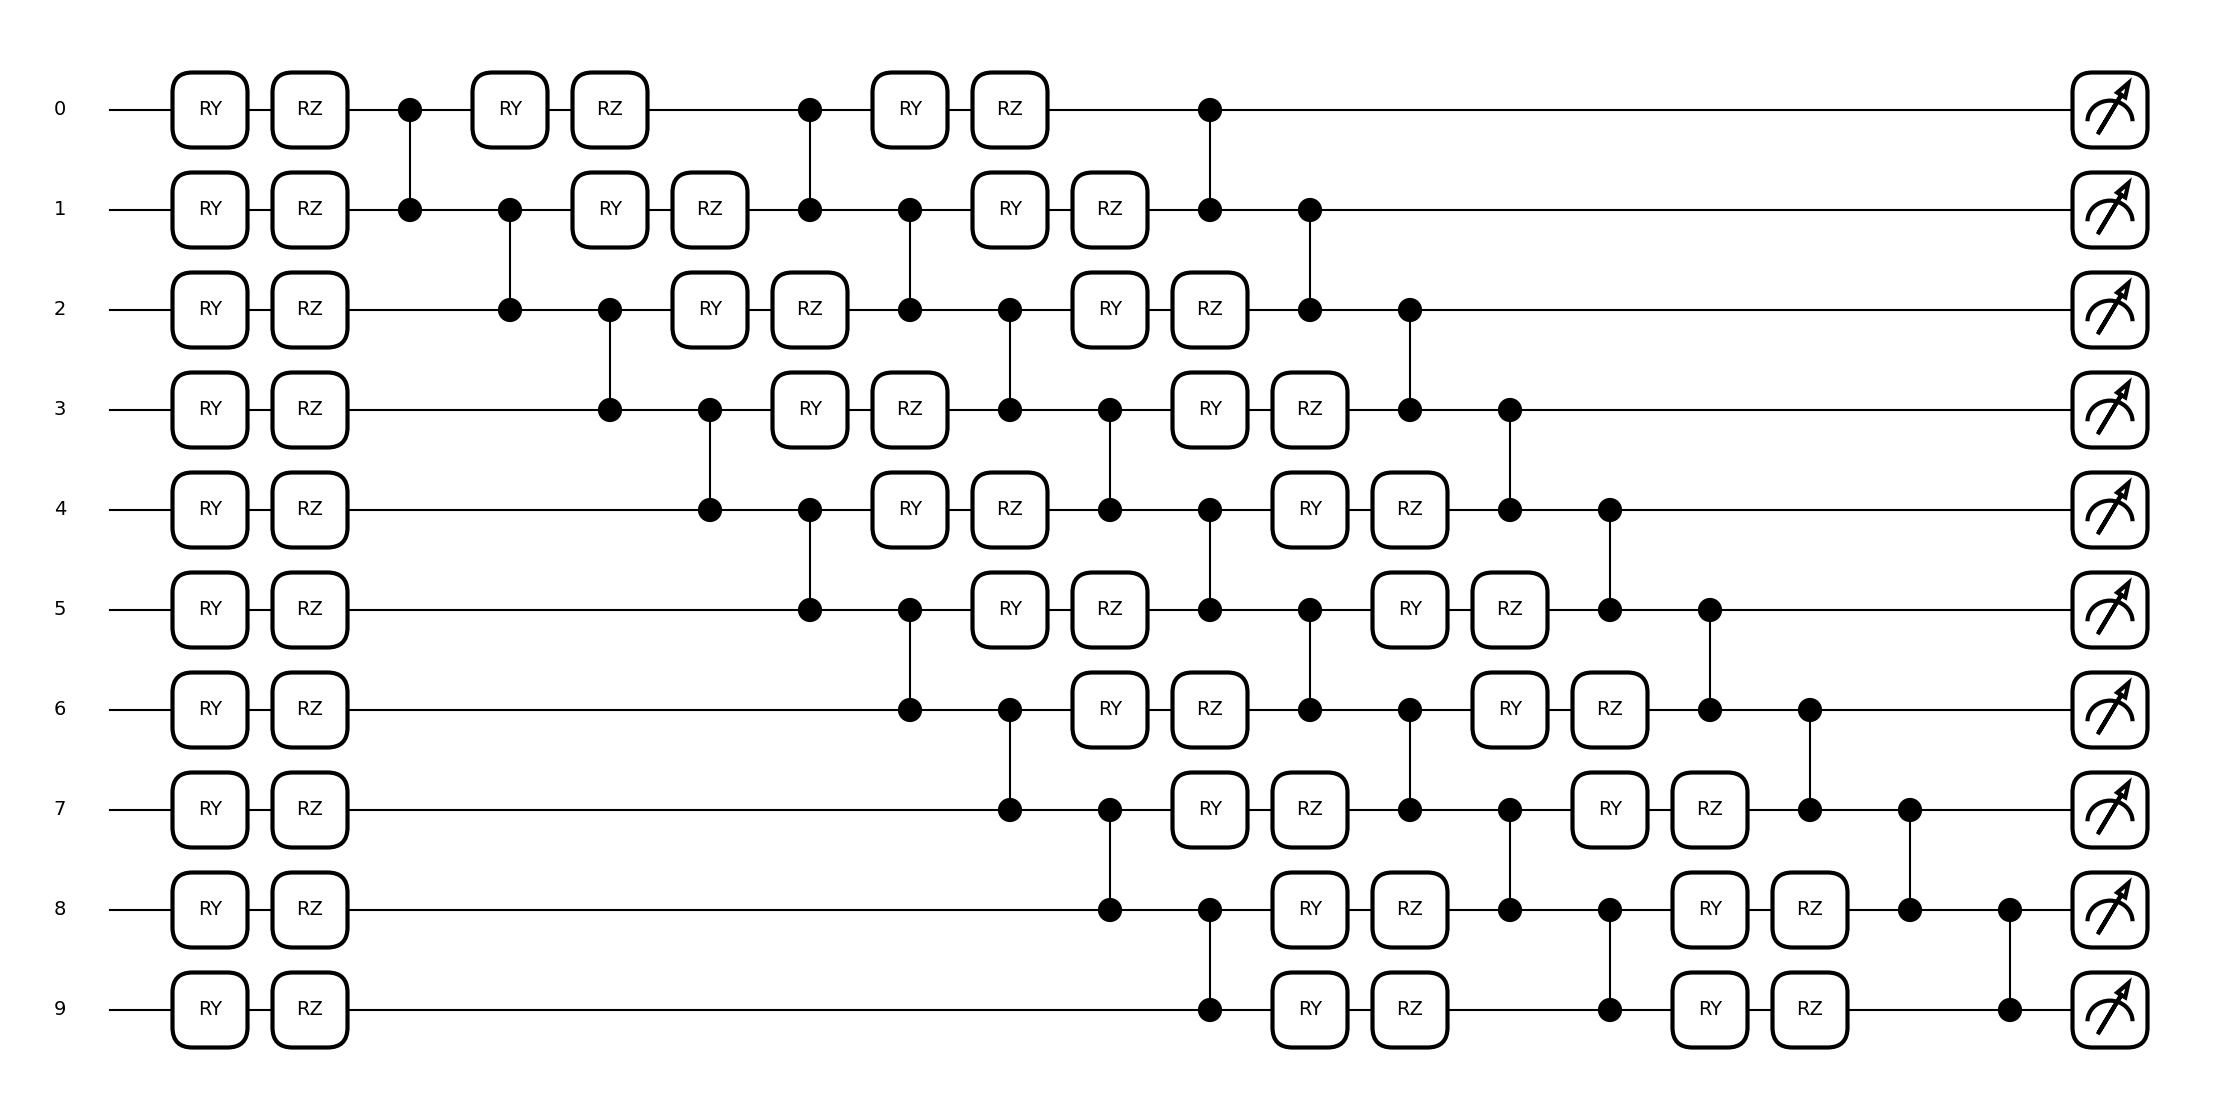

In [60]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# Choose number of qubits
n_qubits = 10   # or 5
REPS = 3

def feature_map(x):
    for r in range(REPS):
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)
            qml.RZ(x[i]**2, wires=i)
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])

# Device only for drawing
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit():
    x = np.zeros(n_qubits)   # dummy input
    feature_map(x)
    return qml.state()

# ✅ ASCII diagram (works in all recent versions)
ascii_diagram = qml.draw(circuit)()
print(ascii_diagram)

# ✅ Matplotlib diagram (graphical)
qml.draw_mpl(circuit)()
plt.show()
